# Simulation of Exome-wide CNV data for case control samples

## Simulation outline
For given type of CNV (e.g. duplication) we first simulate all the variants across exome, 
then assign these simulated CNVs to genes. For case samples we expect an enrichment in causal
genes and the enrichment should be quantified by relative risk of a CNV's contribution to disease
when presented in causal gene vs. non causal gene.

## Parameters
We define causal CNV as CNV in causal gene, and denote it as CCNV. Likewise we have NCNV for non-causal CNV.

| Parameter | Description | Value|
|:-----:|:-----:|:-----:|
|$\lambda$|Average number of CNV per exome| 100 for dup, 20 for del (*FIXME: reference required*)|
|$p_L$|Parameter for Geometric distribution that models length of CNV|To be fitted from data|
|$\gamma$| Odds ratio of CCNV|To draw from distribution Gamma(5, 1)|
|$p_0$| Pr(case &#124; NCNV)| To be calculated below|
|$p_1$| Pr(case &#124; CCNV)| To be calculated from $p_0$ and $\gamma$|
|$N_0, N_1$| Case / Ctrl sample size|Various numbers|
|$q$| Proportion of causal gene|(*FIXME: reference required*)|
|$k$| The prevalence of disease|(*FIXME: reference required*)|

## Simulation steps
The steps below simulates exome data for single individual case or control for one type of CNV. 

### Step 1: Simulate number of CNV per exome
Simply drawn from Pois($\lambda$)

### Step 2: Get the length of each of these CNV simulated
First, separate genome to 10K blocks and find how many CNV overlap (for real data), draw histogram and create a table. Define any block containing 2 or more CNVs as a hotspot.

Second, mimic the distribution of the length of CNV: fit a mixture of geometric, a prop is long tail, a prop is short and a prop is normal.

Finally for each CNV, draw the length of it from the distribution obtained, and set the start point according to the histogram of CNV start point among 10K blocks, and set the length according to mixed geometric.

### Step 3: Get the probability of a sample being case give all CNVs
Suppose $p$ is baseline probability of the disease (prevalence), and $r_0$ is the baseline odds $\frac{p}{1-p}$.

Given simulated CNVs in a sample, the probability for the sample to be case is $p_1$, then the odds ratio for case is $r_1 = r_0 \times R = \frac{p_1}{1-p_1}$, $R$ is the combined relative risks of the all CNVs involved in a sample. Each $R_i$ for causal CNVs is to be sampled from Gamma(1,5), $R = \prod_{i=1}^{\#CNV} R_i$. For noncausal CNV, the $R_i$ is 1. Then $P(case|all CNV) = p_1 = \frac{r_0*R}{1+r_0*R}$, and $P(ctrl|all CNV) = 1-p_1$.

Since $p_1$ is small, about $\frac{1}{p} * n$ trials are to be simulated in order to obtain $n$ cases. However, $n$ controls are easy to obtain.

### Step 4: Check if CNVs overlap with causal gene
Causal/noncausal gene positions are supposed to be determined by literature. But we can simulate randomly for starters.

## Implementation

In [1]:
import random
import pandas as pd
from pandasql import sqldf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import math
%matplotlib inline

In [2]:
ref_gene = pd.read_table("data/refGene.txt.gz", compression="gzip", sep="\t", 
                         header = None, usecols=(1,2,4,5,12), 
                         names = ["tx_name", "chrom", "tx_start", "tx_end", "gene_name"])
#gene_df = ref_gene.drop_duplicates(subset=("chrom", "tx_start", "tx_end", "gene_name"))
gene_df = ref_gene.drop_duplicates(subset=("chrom", "tx_start", "tx_end"))
query = '''
select chrom, gene_name, min(tx_start), max(tx_end)
from gene_df
group by chrom, gene_name
'''
gene_table = sqldf(query)
#print (gene_table)

## Step 1 & 2

In [6]:
filename = "data/ISC-r1.CNV.bed"
cnvbed = {}
dataset = None
for line in open(filename).readlines():
    if not line.startswith("chr"):
        dataset = line.strip().split()[1].lstrip("name=")
        cnvbed[dataset] = {}
        continue
    line = line.strip().split()
    if not line[0] in cnvbed[dataset]:
        cnvbed[dataset][line[0]] = []
    cnvbed[dataset][line[0]].append((int(line[1]),int(line[2])))
    
for dataset in cnvbed.keys():
    for chrom in cnvbed[dataset]:
        cnvbed[dataset][chrom].sort()

cnvbed_df = {}
for dataset in cnvbed.keys():
    cnvbed_df[dataset] = {"chrom":[], "cnv_start":[], "cnv_end":[]}
    for chrom in cnvbed[dataset]:
        start, end = tuple(zip(*cnvbed[dataset][chrom])) 
        cnvbed_df[dataset]["chrom"].extend([chrom] * len(start))
        cnvbed_df[dataset]["cnv_start"] += list(start)
        cnvbed_df[dataset]["cnv_end"] += list(end)
    cnvbed_df[dataset] = pd.DataFrame.from_dict(cnvbed_df[dataset]).drop_duplicates(
                                            subset=("chrom", "cnv_start", "cnv_end"))
print (cnvbed_df)

{'dupControls':       chrom    cnv_end  cnv_start
0      chr4     192796      55677
1      chr4     190632      58821
2      chr4     192796      58821
3      chr4     240067     110944
4      chr4     250808     133439
5      chr4     302482     200096
6      chr4     380687     256863
7      chr4    3225269    2943461
8      chr4    4972110    4627826
9      chr4    7871489    7340508
10     chr4    7871489    7340508
11     chr4    9133247    8842614
12     chr4    9147528    9046959
13     chr4    9147528    9046959
14     chr4    9162357    9046959
15     chr4    9177664    9046959
16     chr4    9168219    9048572
17     chr4    9171010    9048572
18     chr4    9174136    9048572
19     chr4    9310260    9162356
20     chr4    9326868    9223591
21     chr4   22479717   22268861
22     chr4   22689901   22542427
23     chr4   33876324   33562102
24     chr4   40620897   40512226
25     chr4   40621293   40512226
26     chr4   40621293   40519602
27     chr4   43061614   4266068

192471.0


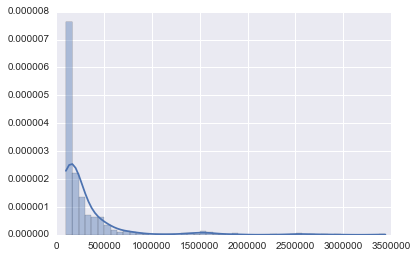

In [7]:
cnv_length = {}
for name, value in cnvbed_df.items():
    query = """
    SELECT cnv_end-cnv_start
    FROM value
    """
    cnv_length[name] = sqldf(query)
    cnv_length[name] = cnv_length[name].rename(columns={"cnv_end-cnv_start": "cnv_length"})

#print (cnv_length["delCases"])
print (np.median(cnv_length["dupCases"]))
sns.distplot(cnv_length["delCases"][0:800])
#plt.plot(cnv_length["delControls"])

In [8]:
cnv_overlap = {}
for name, value in cnvbed_df.items():
    query = """
    WHERE 
    """

In [153]:
n1 = 20 # to be obtained from literature
n2 = 80 # to be obtained from literature
p_del = 0.00006 # to be obtained from real data
p_dup = 0.00004 # to be obtained from real data
n_delcase = 1000
n_delctrl = 1000
n_dupcase = 1000
n_dupctrl = 1000
n_del = n_delcase+n_delctrl
n_dup = n_dupcase+n_dupctrl
k = 0.001 # prevalence of the disease
q = 0.002 # q: Proportion of causal gene
shape = 5
scale = 1

In [25]:
def delCNV(n1):
    n_del = np.random.poisson(n1)
    len_delcnv = np.random.geometric(p=p_del, size=n_del)+10000
    return len_delcnv

def dupCNV(n2):
    n_dup = np.random.poisson(n2)
    len_dupcnv = np.random.geometric(p=p_dup, size=n_dup)+10000
    return len_dupcnv

## Step 3

In [ ]:
def genegroup(genelist):
    cslgene = random.sample(genelist, int(q*len(genelist)))
    noncslgene = genelist - cslgene
    return (cslgene, noncslgene)

def p_case(q,k):
    # p1: Pr(case | CCNV), p0: Pr(case | NCNV)
    rv = np.random.gamma(shape, scale)
    a = q*rv-q
    b = k-k*rv-q*rv+q-1
    c = k*rv
    p1 = (-b-math.sqrt(b**2-4*a*c)) / (2*a)
    p_ccnv_case = p1*q / k
    p_ncnv_case = 1 - p_ccnv_case
    return (p_ccnv_case, p_ncnv_case)

def p_ctrl(q):
    p_ccnv_ctrl = q
    p_ncnv_ctrl = 1-q
    return (p_ccnv_ctrl, p_ncnv_ctrl)

### Trial

In [79]:
def cnvg(shape, scale):
    k = 0.01 # prevalence of the disease
    q = 0.02 # q: Proportion of causal gene
    r = np.random.gamma(shape, scale)
    print (r)
    a = q*r-q
    b = k-k*r-q*r+q-1
    c = k*r
    p1 = (-b-math.sqrt(b**2-4*a*c)) / (2*a)
    print (p1)
    p_ccnv_case = p1*q/k
    p_ncnv_case = 1 - p_ccnv_case
    return (p_ccnv_case, p_ncnv_case)
cnvg(5,1)

4.889419045453884
0.043919588316617804


(0.08783917663323561, 0.9121608233667644)

In [152]:
def CNVcase(delCNV):
    cslcnv = []
    CCNV = np.random.binomial(1, p_ccnv_case)
    if CCNV==1:
        cslcnv.append()